In [12]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tqdm import tqdm
import json 
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import random


import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


from transformers import BertTokenizer
nltk.download('punkt_tab')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading package punkt_tab to /Users/chi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [13]:
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_dim, n_layers, bidirectional, dropout):
        
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        lstm_out, _ = self.lstm(embedded)
        output = self.fc(lstm_out[:, -1, :])
        return output
    

# Training function
def train_lstm(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    total_acc = 0


    # Wrap the dataloader with tqdm for progress tracking
    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)

       
        # Forward pass
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

    return total_loss / len(dataloader), total_acc / len(dataloader)


# Evaluation function
def evaluate_lstm(model, dataloader):
    model.eval()
    total_acc = 0

    with torch.no_grad():
        # Wrap the dataloader with tqdm for progress tracking
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids)
            preds = torch.argmax(outputs, dim=1)

            total_acc += accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

    return total_acc / len(dataloader)



In [14]:
file_path = 'sampled_preprocessed.json'
df = pd.read_json(file_path)

In [15]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['is_spoiler'])

# Split the data before applying SMOTE
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Calculate original class distribution



# # Vectorization and SMOTE
# vectorizer = TfidfVectorizer()
# X_train_tfidf = vectorizer.fit_transform(train_df['cleaned_review_text'])  # Convert text to TF-IDF
y_train = train_df['label']

# print("Original dataset shape:", type(X_train_tfidf))


# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_train_tfidf, y_train)

# # Check the resampled data
# print("Resampled dataset shape:", X_resampled.shape)

# train_df_resampled = pd.DataFrame(X_resampled.todense(), columns=vectorizer.get_feature_names_out())
# train_df_resampled['label'] = y_resampled

# # 5. Re-split the temporary set into validation and test sets (50% each)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

# print("Train (Resampled) Shape:", train_df_resampled.shape)
# print("Validation Shape:", val_df.shape)
# print("Test Shape:", test_df.shape)
# Tokenization
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class SpoilerDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = tokenizer.encode_plus(
            text,
            max_length=512,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [17]:
batch_size = 32
# Create datasets with the resampled training data
train_dataset = SpoilerDataset(train_df['cleaned_review_text'].tolist(), train_df['label'].tolist())
val_dataset = SpoilerDataset(val_df['cleaned_review_text'].tolist(), val_df['label'].tolist())
test_dataset = SpoilerDataset(test_df['cleaned_review_text'].tolist(), test_df['label'].tolist())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Hyperparameters
embedding_dim = 100
hidden_dim = 128
vocab_size = tokenizer.vocab_size
output_dim = 2
n_layers = 3
bidirectional = True
dropout = 0.5



# Instantiate model, loss function, optimizer
lstm_model = LSTMClassifier(embedding_dim, hidden_dim, vocab_size, output_dim, n_layers, bidirectional, dropout)
lstm_model = lstm_model.to(device)
optimizer = Adam(lstm_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


In [19]:
train_losses = []
train_accuracies = []
val_accuracies = []

n_epochs = 8
# Initialize tqdm progress bar
for epoch in tqdm(range(n_epochs), desc='Training Epochs'):
    train_loss, train_acc = train_lstm(lstm_model, train_loader, optimizer, criterion)
    val_acc = evaluate_lstm(lstm_model, val_loader)
    
    # Append metrics to lists
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    # Print epoch information
    tqdm.write(f'Epoch {epoch+1}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}, Val Acc {val_acc:.4f}')
    
    # # Save model checkpoint every 10 epochs
    # if (epoch + 1) % 10 == 0:
    #     checkpoint_path = f'lstm_model_epoch_{epoch+1}.pth'
    #     torch.save(lstm_model.state_dict(), checkpoint_path)
    #     print(f'Model checkpoint saved to {checkpoint_path}')

# Evaluate on test set
test_acc = evaluate_lstm(lstm_model, test_loader)
print(f'Test Accuracy: {test_acc:.4f}')

Training Epochs:  12%|█▎        | 1/8 [01:10<08:13, 70.55s/it]

Epoch 1: Train Loss 0.5704, Train Acc 0.7388, Val Acc 0.7166


Training Epochs:  25%|██▌       | 2/8 [02:27<07:26, 74.36s/it]

Epoch 2: Train Loss 0.5663, Train Acc 0.7451, Val Acc 0.7340


Training Epochs:  38%|███▊      | 3/8 [03:45<06:20, 76.04s/it]

Epoch 3: Train Loss 0.5631, Train Acc 0.7510, Val Acc 0.7270


Training Epochs:  50%|█████     | 4/8 [05:02<05:04, 76.21s/it]

Epoch 4: Train Loss 0.5596, Train Acc 0.7545, Val Acc 0.7340


Training Epochs:  62%|██████▎   | 5/8 [06:18<03:48, 76.29s/it]

Epoch 5: Train Loss 0.5517, Train Acc 0.7578, Val Acc 0.7201


Training Epochs:  75%|███████▌  | 6/8 [07:34<02:32, 76.04s/it]

Epoch 6: Train Loss 0.5506, Train Acc 0.7564, Val Acc 0.7305


Training Epochs:  88%|████████▊ | 7/8 [08:50<01:16, 76.10s/it]

Epoch 7: Train Loss 0.5489, Train Acc 0.7598, Val Acc 0.7131


Training Epochs: 100%|██████████| 8/8 [10:05<00:00, 75.68s/it]


Epoch 8: Train Loss 0.5425, Train Acc 0.7633, Val Acc 0.7236


Evaluating: 100%|██████████| 9/9 [00:03<00:00,  2.74it/s]

Test Accuracy: 0.7281


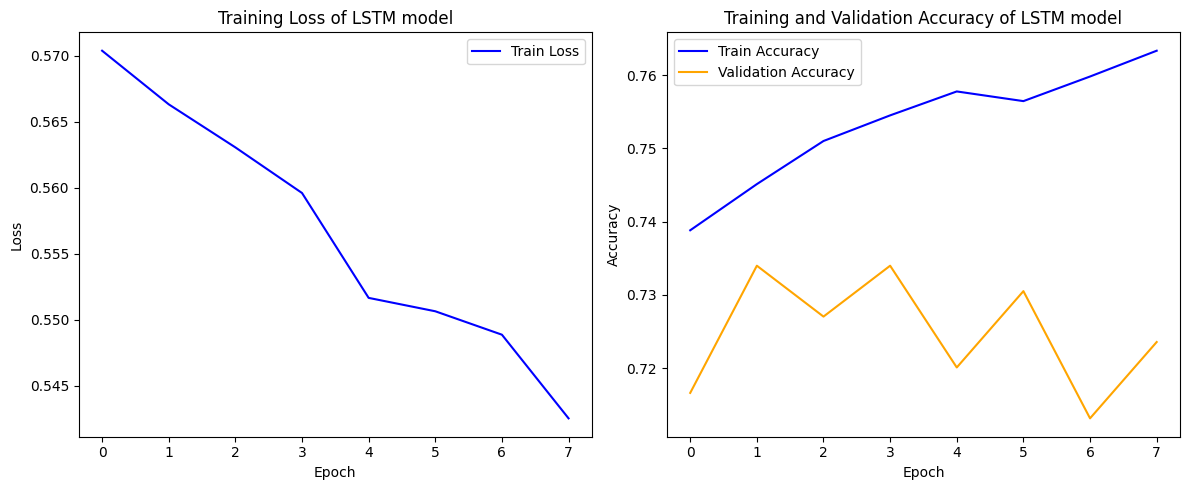

In [20]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(n_epochs), train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss of LSTM model')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(n_epochs), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(n_epochs), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy of LSTM model')
plt.legend()

plt.tight_layout()
plt.show()